# Imports

In [33]:
# Base
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

# Data-Science
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DebertaV2Tokenizer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from textstat import flesch_reading_ease, flesch_kincaid_grade, gunning_fog

# Data Wrangling

In [8]:
df_ai = pd.read_csv("ai_text_detection_ai_100k_sample.csv")
df_ai

,source,text
0,1,Drywall and floorboard installation\n\nWall in...
1,1,1. Get an E-Nanny\n\n\nWhat: Get an e-nanny.\n...
2,1,"In a recent interview with the New York Times,..."
3,1,The White House has was forced to defend its c...
4,1,The U.S. government is sending an extra $35 mi...
...,...,...
99995,1,"HANOVER, N.J. (March 8, 2014) – Jurgen Klinsma..."
99996,1,A barium CT scan is a type of imaging test tha...
99997,1,Milo Yiannopoulos has responded to outrage at ...
99998,1,"RICHARD B. CLAY, a former Republican congressm..."


In [9]:
# Check for missing values in AI text dataset
df_ai.isnull().sum()

source     0
text      44
dtype: int64

In [10]:
df_ai = df_ai.dropna()
df_ai

,source,text
0,1,Drywall and floorboard installation\n\nWall in...
1,1,1. Get an E-Nanny\n\n\nWhat: Get an e-nanny.\n...
2,1,"In a recent interview with the New York Times,..."
3,1,The White House has was forced to defend its c...
4,1,The U.S. government is sending an extra $35 mi...
...,...,...
99995,1,"HANOVER, N.J. (March 8, 2014) – Jurgen Klinsma..."
99996,1,A barium CT scan is a type of imaging test tha...
99997,1,Milo Yiannopoulos has responded to outrage at ...
99998,1,"RICHARD B. CLAY, a former Republican congressm..."


In [11]:
# Check for missing values in AI text dataset
df_ai.isnull().sum()

source    0
text      0
dtype: int64

In [ ]:
df_ai["text_length"] = df_ai["text"].apply(len)
df_ai["word_count"] = df_ai["text"].apply(lambda x: len(x.split()))
df_ai["avg_word_length"] = df_ai["text"].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)
df_ai["sentence_count"] = df_ai["text"].apply(lambda x: x.count(".") + x.count("!") + x.count("?"))
df_ai["avg_sentence_length"] = df_ai["text_length"] / (df_ai["sentence_count"] + 1)

In [13]:
df_ai["text_length"].describe()

count    99956.000000
mean      2214.678108
std       1690.633782
min          1.000000
25%        635.000000
50%       1763.000000
75%       3973.000000
max       6242.000000
Name: text_length, dtype: float64

In [14]:
df_human = pd.read_csv("ai_text_detection_human_100k_sample.csv")
df_human

,source,text
0,0,From Trailville\n\nUpper Des Plaines River Can...
1,0,Coca-Cola Company’s Performance Measurement Es...
2,0,"I can't stop it, you won't like it, you should..."
3,0,"American Sniper, the Clint Eastwood movie abou..."
4,0,eating them.'' His jaw was clenched so tight t...
...,...,...
99995,0,Sixty members of the U.S. House of Representat...
99996,0,Chapters 7-9 in “Understanding Comics” by McCl...
99997,0,isms and secret little snarky remarks. The key...
99998,0,"see, a small town right off Interstate 75. I g..."


In [15]:
# Check for missing values in Human text dataset
df_human.isnull().sum()

source    0
text      0
dtype: int64

In [16]:
df_human["text_length"] = df_human["text"].apply(len)
df_human["word_count"] = df_human["text"].apply(lambda x: len(x.split()))
df_human["avg_word_length"] = df_human["text"].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)
df_human["sentence_count"] = df_human["text"].apply(lambda x: x.count(".") + x.count("!") + x.count("?"))
df_human["avg_sentence_length"] = df_human["text_length"] / (df_human["sentence_count"] + 1)

In [17]:
df_human["text_length"].describe()

count    100000.000000
mean       2470.603990
std        4292.574364
min          23.000000
25%         988.000000
50%         996.000000
75%        2400.250000
max      212456.000000
Name: text_length, dtype: float64

### Basic Graphs

This histogram compares the distribution of text lengths in both human-written and AI-generated texts. Human-written texts have a wider range of lengths, while AI-generated texts tend to be more concentrated around specific lengths.

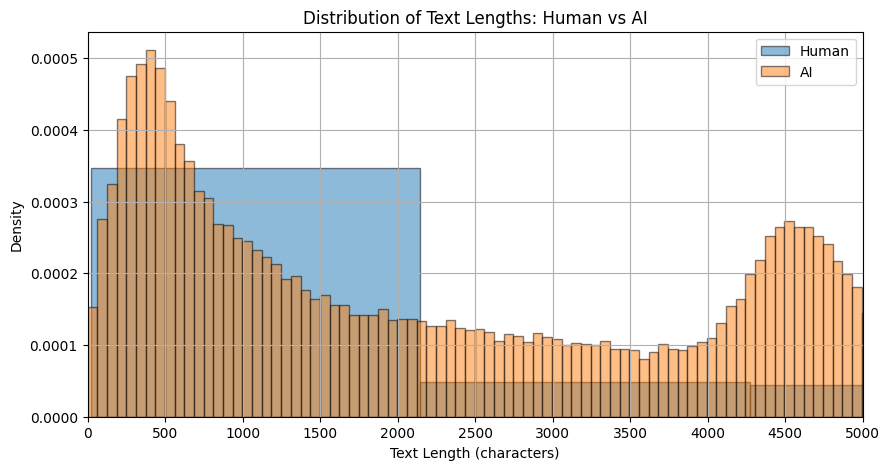

In [18]:
plt.figure(figsize=(10, 5))
plt.hist(df_human["text_length"], bins=100, alpha=0.5, label="Human", edgecolor="black", density=True)
plt.hist(df_ai["text_length"], bins=100, alpha=0.5, label="AI", edgecolor="black", density=True)
plt.xlabel("Text Length (characters)")
plt.ylabel("Density")
plt.title("Distribution of Text Lengths: Human vs AI")
plt.legend()
plt.grid(True)
plt.xlim(0, 5000)
plt.xticks(range(0, 5500, 500))
plt.show()


The violin plot illustrates the distribution of text lengths with density curves. It shows that human-written texts have a higher variability, including extreme outliers, while AI-generated texts tend to be more uniform.

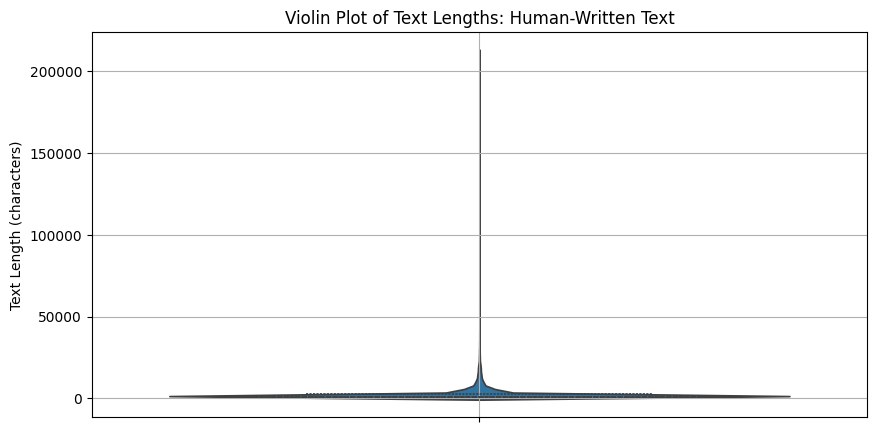

In [19]:
plt.figure(figsize=(10, 5))
sns.violinplot(y=df_human["text_length"], inner="quartile")
plt.ylabel("Text Length (characters)")
plt.title("Violin Plot of Text Lengths: Human-Written Text")
plt.grid(True)
plt.show()

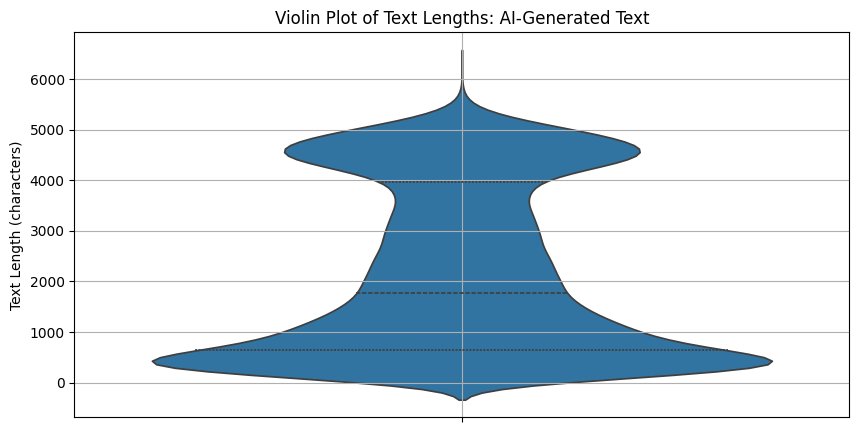

In [20]:
plt.figure(figsize=(10, 5))
sns.violinplot(y=df_ai["text_length"], inner="quartile")
plt.ylabel("Text Length (characters)")
plt.title("Violin Plot of Text Lengths: AI-Generated Text")
plt.grid(True)
plt.show()

This histogram compares the distribution of word counts in human-written and AI-generated texts. Similar to text length, human-written texts have a broader distribution with some extreme values, while AI-generated texts tend to cluster in a specific range.

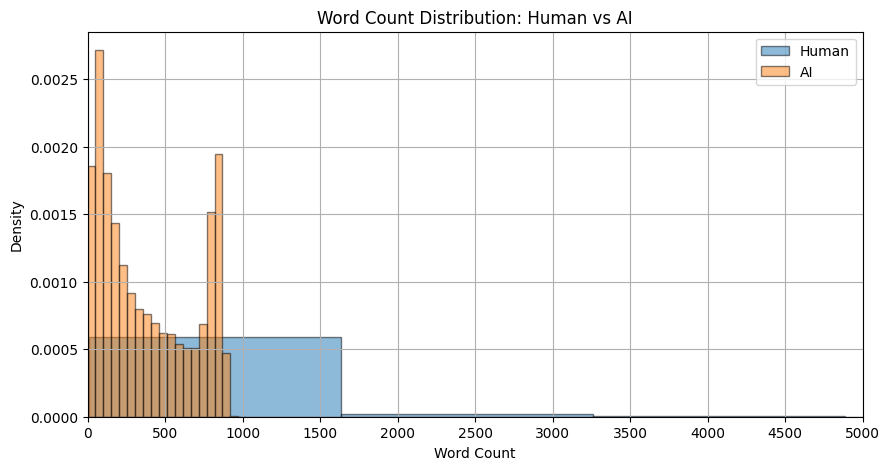

In [21]:
plt.figure(figsize=(10, 5))
plt.hist(df_human["word_count"], bins=20, alpha=0.5, label="Human", edgecolor="black", density=True)
plt.hist(df_ai["word_count"], bins=20, alpha=0.5, label="AI", edgecolor="black", density=True)
plt.xlabel("Word Count")
plt.ylabel("Density")
plt.title("Word Count Distribution: Human vs AI")
plt.legend()
plt.xlim(0, 5000)
plt.xticks(range(0, 5500, 500))
plt.grid(True)
plt.show()

This histogram shows the distribution of average word lengths in human-written and AI-generated texts. Both categories seem to have similar word lengths on average, but minor variations could be important for classification.

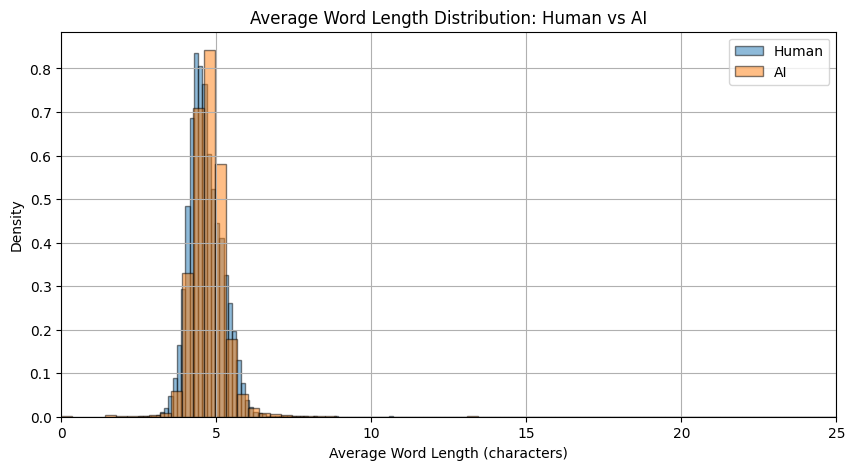

In [22]:

plt.figure(figsize=(10, 5))
plt.hist(df_human["avg_word_length"], bins=1000, alpha=0.5, label="Human", edgecolor="black", density=True)
plt.hist(df_ai["avg_word_length"], bins=1000, alpha=0.5, label="AI", edgecolor="black", density=True)
plt.xlabel("Average Word Length (characters)")
plt.ylabel("Density")
plt.title("Average Word Length Distribution: Human vs AI")
plt.legend()
plt.xlim(0, 25)
plt.xticks(range(0, 30, 5))
plt.grid(True)
plt.show()

This histogram compares the number of sentences per text in human-written and AI-generated content. AI-generated texts often have a more predictable sentence structure, while human-written texts show greater variation.

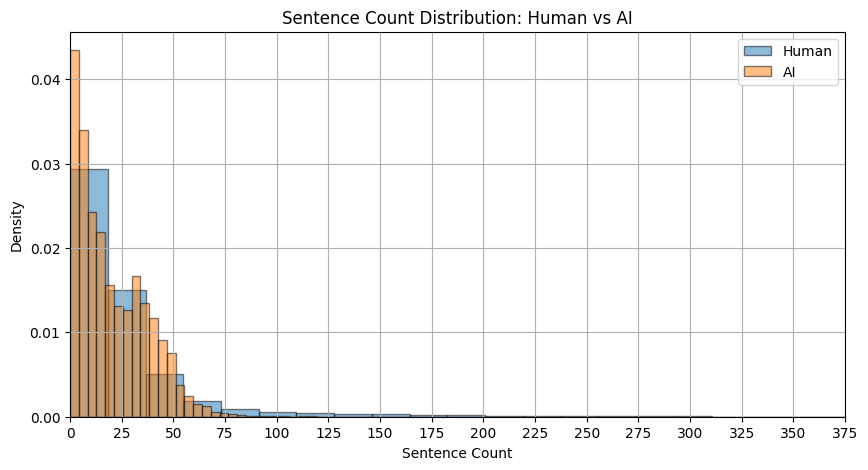

In [23]:
plt.figure(figsize=(10, 5))
plt.hist(df_human["sentence_count"], bins=100, alpha=0.5, label="Human", edgecolor="black", density=True)
plt.hist(df_ai["sentence_count"], bins=100, alpha=0.5, label="AI", edgecolor="black", density=True)
plt.xlabel("Sentence Count")
plt.ylabel("Density")
plt.title("Sentence Count Distribution: Human vs AI")
plt.legend()
plt.xlim(0, 350)
plt.xticks(range(0, 400, 25))
plt.grid(True)
plt.show()

This histogram illustrates the distribution of average sentence lengths in human and AI-generated texts. AI-generated texts might follow more structured and formulaic sentence lengths, while human texts show greater variation.

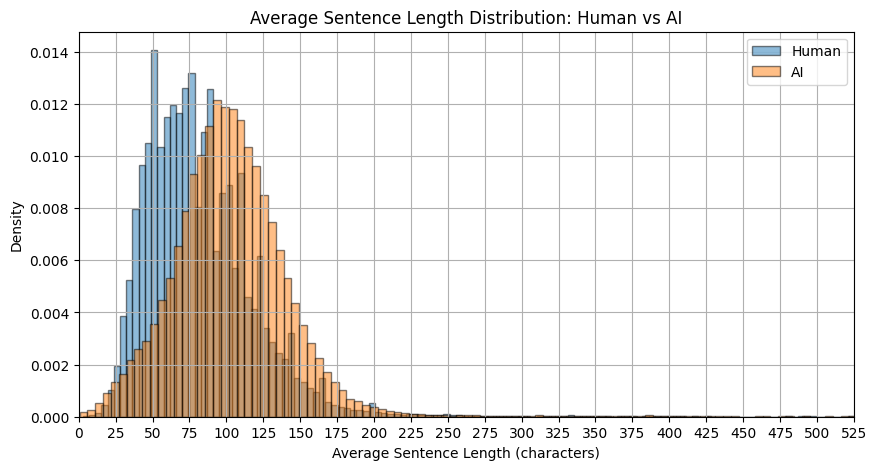

In [24]:
plt.figure(figsize=(10, 5))
plt.hist(df_human["avg_sentence_length"], bins=1000, alpha=0.5, label="Human", edgecolor="black", density=True)
plt.hist(df_ai["avg_sentence_length"], bins=1000, alpha=0.5, label="AI", edgecolor="black", density=True)
plt.xlabel("Average Sentence Length (characters)")
plt.ylabel("Density")
plt.title("Average Sentence Length Distribution: Human vs AI")
plt.legend()
plt.xlim(0, 500)
plt.xticks(range(0, 550, 25))
plt.grid(True)
plt.show()

### Advanced Graphs

This histogram compares lexical diversity (ratio of unique words to total words) in human vs AI text. Human-written texts tend to have **higher lexical diversity**, meaning they use a **wider variety of words**, whereas AI-generated text is more repetitive

Lexical Diversity Key Findings:
- Human-written text tends to have higher lexical diversity (a greater variety of words relative to total words).
- AI-generated text is more repetitive, likely due to model constraints on vocabulary usage.
- This feature can be useful in classification models, as AI text might have a narrower vocabulary range than human text.

/var/folders/p4/qsndzg250w3_83_hx1zq1bpc0000gn/T/ipykernel_19680/443831339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ai["lexical_diversity"] = df_ai["text"].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)


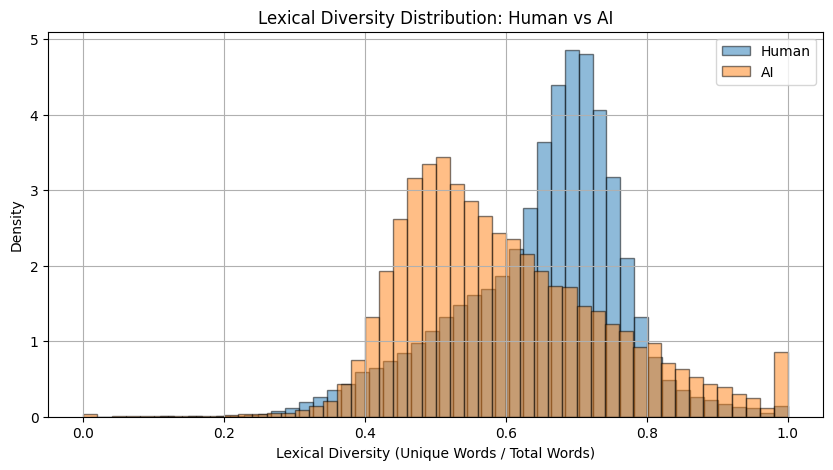

In [25]:
# 1. Lexical Diversity Analysis
df_human["lexical_diversity"] = df_human["text"].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
df_ai["lexical_diversity"] = df_ai["text"].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)

plt.figure(figsize=(10, 5))
plt.hist(df_human["lexical_diversity"], bins=50, alpha=0.5, label="Human", edgecolor="black", density=True)
plt.hist(df_ai["lexical_diversity"], bins=50, alpha=0.5, label="AI", edgecolor="black", density=True)
plt.xlabel("Lexical Diversity (Unique Words / Total Words)")
plt.ylabel("Density")
plt.title("Lexical Diversity Distribution: Human vs AI")
plt.legend()
plt.grid(True)
plt.show()

This histogram compares stopword usage (common words like 'the', 'is', 'and') in human vs AI text. Human-written texts **tend to use more stopwords**, making them sound more natural. AI-generated texts may avoid excessive stopwords, potentially making them sound more structured.

Stopword Usage Key Findings:
- Human-written text has a higher ratio of stopwords (e.g., "the", "is", "and"), making it sound more natural and conversational.
- AI-generated text appears to have a lower stopword ratio, potentially making it feel more structured and less fluid.
- This feature can be a useful indicator for AI text detection models.

/var/folders/p4/qsndzg250w3_83_hx1zq1bpc0000gn/T/ipykernel_19680/2420047724.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ai["stopword_ratio"] = df_ai["text"].apply(manual_stopword_ratio)


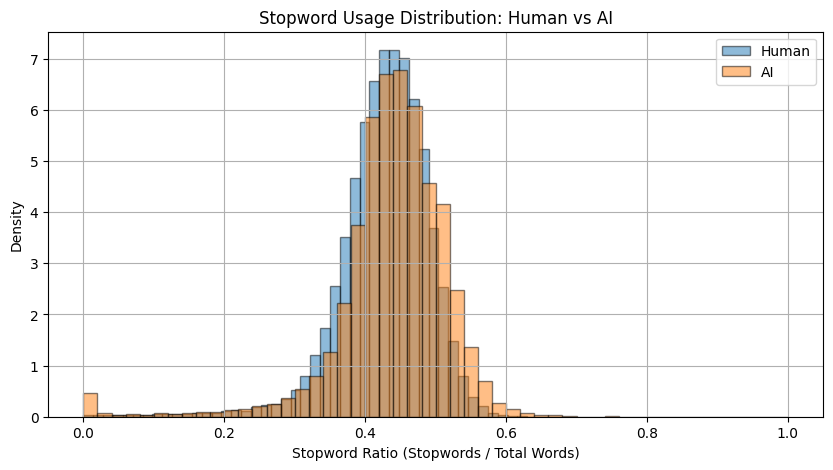

In [26]:
manual_stopwords = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was",
    "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and",
    "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between",
    "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off",
    "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any",
    "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"
])

# Function to compute stopword ratio using the manually defined stopwords
def manual_stopword_ratio(text):
    words = text.split()
    if len(words) == 0:
        return 0
    stopword_count = sum(1 for word in words if word.lower() in manual_stopwords)
    return stopword_count / len(words)

# Compute stopword ratio for both datasets
df_human["stopword_ratio"] = df_human["text"].apply(manual_stopword_ratio)
df_ai["stopword_ratio"] = df_ai["text"].apply(manual_stopword_ratio)

# Plot stopword usage distribution
plt.figure(figsize=(10, 5))
plt.hist(df_human["stopword_ratio"], bins=50, alpha=0.5, label="Human", edgecolor="black", density=True)
plt.hist(df_ai["stopword_ratio"], bins=50, alpha=0.5, label="AI", edgecolor="black", density=True)
plt.xlabel("Stopword Ratio (Stopwords / Total Words)")
plt.ylabel("Density")
plt.title("Stopword Usage Distribution: Human vs AI")
plt.legend()
plt.grid(True)
plt.show()

 This bar chart compares the most frequently used words in human vs AI text. |Differences in commonly used words may indicate structural or linguistic patterns unique to AI-generated content.

Common Word Frequency Key Findings:
- This alternative analysis compares the most frequent words in human vs AI text, acting as a proxy for POS tagging.
- AI-generated text may have different word preferences compared to human writing, potentially favoring more structured or formal expressions.
- Human-written text might contain more personal pronouns, conversational fillers, and diverse phrasing.

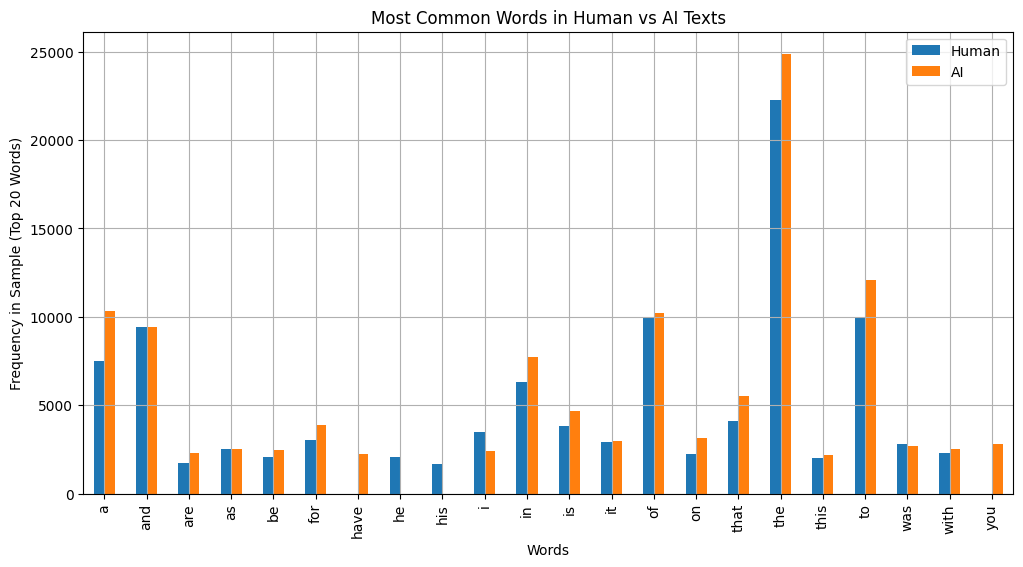

In [27]:
# Function to get word frequency
def get_word_frequencies(text_list):
    word_counts = Counter()
    for text in text_list:
        words = text.lower().split()
        word_counts.update(words)
    return word_counts

# Compute word frequencies for both datasets (using a sample for efficiency)
sample_size = 1000
human_sample_texts = df_human["text"].sample(sample_size, random_state=42)
ai_sample_texts = df_ai["text"].sample(sample_size, random_state=42)

human_word_freq = get_word_frequencies(human_sample_texts)
ai_word_freq = get_word_frequencies(ai_sample_texts)

# Convert to DataFrame
human_top_words = pd.DataFrame(human_word_freq.most_common(20), columns=["Word", "Human Frequency"])
ai_top_words = pd.DataFrame(ai_word_freq.most_common(20), columns=["Word", "AI Frequency"])

# Merge both datasets for comparison
word_freq_df = human_top_words.merge(ai_top_words, on="Word", how="outer").fillna(0)
word_freq_df.set_index("Word", inplace=True)

# Plot word frequency comparison
word_freq_df.plot(kind="bar", figsize=(12, 6))
plt.xlabel("Words")
plt.ylabel("Frequency in Sample (Top 20 Words)")
plt.title("Most Common Words in Human vs AI Texts")
plt.legend(["Human", "AI"])
plt.grid(True)
plt.show()

This histogram compares the Flesch Reading Ease scores for human and AI text. A lower score means the text is **harder to read**. AI-generated text might have different readability patterns compared to human writing, often making it **more structured but less natural**

Readability Score Key Findings (Expected Results):
- Human-written text typically has higher variability in readability scores.
- AI-generated text may score consistently higher or lower, depending on the model used (some AI-generated text is overly structured).
- Lower Flesch Reading Ease scores indicate more complex text, which AI might unintentionally produce due to lack of natural flow.

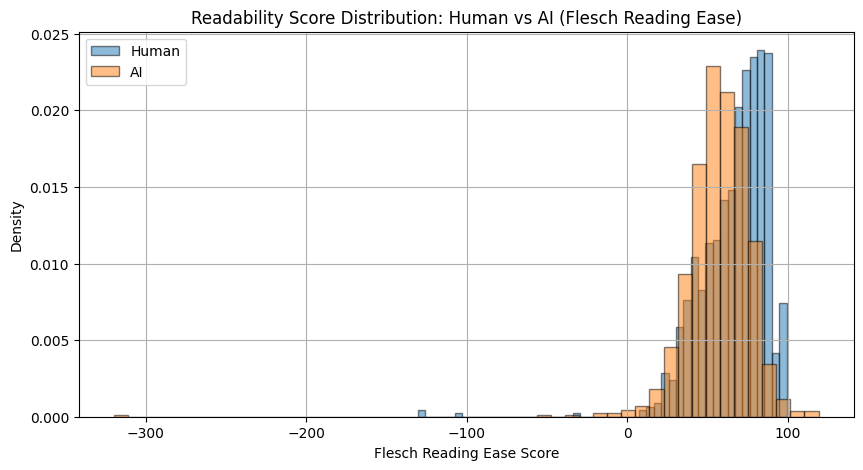

In [28]:
# Function to compute readability scores
def compute_readability_scores(text):
    return {
        "flesch_reading_ease": flesch_reading_ease(text),
        "flesch_kincaid_grade": flesch_kincaid_grade(text),
        "gunning_fog": gunning_fog(text)
    }

# Compute readability scores for a sample subset
sample_size = 1000
human_sample = df_human["text"].sample(sample_size, random_state=42)
ai_sample = df_ai["text"].sample(sample_size, random_state=42)

human_readability = pd.DataFrame([compute_readability_scores(text) for text in human_sample])
ai_readability = pd.DataFrame([compute_readability_scores(text) for text in ai_sample])

# Plot readability score comparisons
plt.figure(figsize=(10, 5))
plt.hist(human_readability["flesch_reading_ease"], bins=50, alpha=0.5, label="Human", edgecolor="black", density=True)
plt.hist(ai_readability["flesch_reading_ease"], bins=50, alpha=0.5, label="AI", edgecolor="black", density=True)
plt.xlabel("Flesch Reading Ease Score")
plt.ylabel("Density")
plt.title("Readability Score Distribution: Human vs AI (Flesch Reading Ease)")
plt.legend()
plt.grid(True)
plt.show()


This histogram compares the average words per sentence in human and AI text. Human-written text might have **more varied sentence structures**, whereas AI text may have **more consistent sentence lengths**

Sentence Complexity Key Findings:
- Human-written text typically has greater variability in sentence length, indicating a mix of short and complex sentences.
- AI-generated text may have a more uniform sentence length, reflecting structured patterns often seen in language models.
- This can be a useful feature in classification models, as human text varies more in sentence complexity.

/var/folders/p4/qsndzg250w3_83_hx1zq1bpc0000gn/T/ipykernel_19680/4096901541.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ai["sentence_complexity"] = df_ai["text"].apply(compute_sentence_complexity)


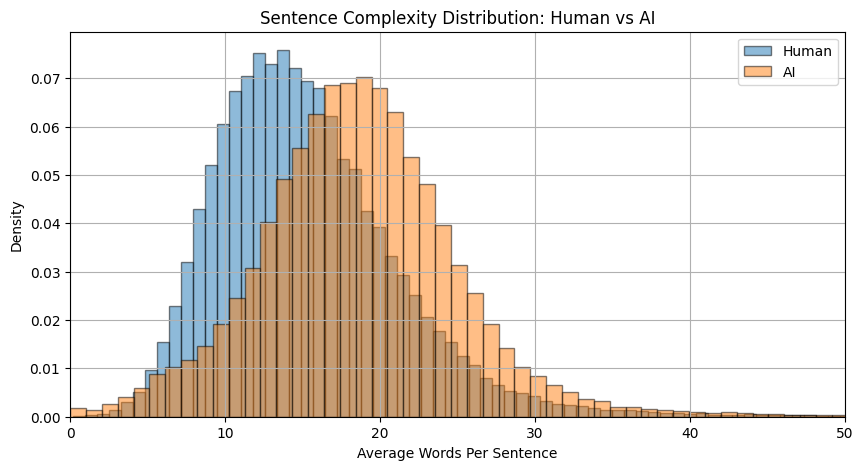

In [29]:
# Function to compute sentence complexity (average words per sentence)
def compute_sentence_complexity(text):
    sentences = text.split('.')
    num_sentences = len(sentences)
    num_words = len(text.split())
    return num_words / num_sentences if num_sentences > 0 else 0

# Compute sentence complexity for both datasets
df_human["sentence_complexity"] = df_human["text"].apply(compute_sentence_complexity)
df_ai["sentence_complexity"] = df_ai["text"].apply(compute_sentence_complexity)

# Plot sentence complexity comparison
plt.figure(figsize=(10, 5))
plt.hist(df_human["sentence_complexity"], bins=1000, alpha=0.5, label="Human", edgecolor="black", density=True)
plt.hist(df_ai["sentence_complexity"], bins=1000, alpha=0.5, label="AI", edgecolor="black", density=True)
plt.xlabel("Average Words Per Sentence")
plt.ylabel("Density")
plt.title("Sentence Complexity Distribution: Human vs AI")
plt.legend()
plt.grid(True)
plt.xlim(0, 50)  # Limiting for better visualization
plt.show()

This histogram compares how often pronouns are used in human vs AI text. Human writing may use **more first-person pronouns (I, we, me)**, while AI-generated text might use fewer personal references or favor third-person pronouns

Pronoun Usage Key Findings:
- Human-written text often contains more first-person pronouns (e.g., "I", "we", "me"), reflecting personal opinions, experiences, or narratives.
- AI-generated text may use fewer personal pronouns and favor third-person references, leading to a more neutral or objective tone.
- This feature can be valuable in AI detection, as excessive or reduced pronoun usage may help differentiate between AI and human text.

/var/folders/p4/qsndzg250w3_83_hx1zq1bpc0000gn/T/ipykernel_19680/3946741808.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ai["pronoun_ratio"] = df_ai["text"].apply(compute_pronoun_ratio)


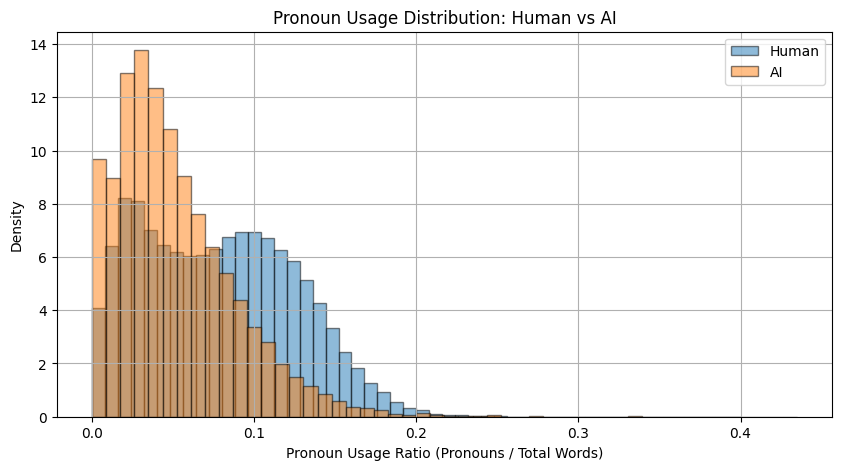

In [30]:
# List of common pronouns to analyze
pronouns = {"i", "me", "my", "mine", "myself", "we", "our", "ours", "ourselves",
            "you", "your", "yours", "yourself", "yourselves",
            "he", "him", "his", "himself", "she", "her", "hers", "herself",
            "it", "its", "itself", "they", "them", "their", "theirs", "themselves"}

# Function to compute pronoun frequency ratio
def compute_pronoun_ratio(text):
    words = text.lower().split()
    pronoun_count = sum(1 for word in words if word in pronouns)
    return pronoun_count / len(words) if len(words) > 0 else 0

# Compute pronoun ratios for both datasets
df_human["pronoun_ratio"] = df_human["text"].apply(compute_pronoun_ratio)
df_ai["pronoun_ratio"] = df_ai["text"].apply(compute_pronoun_ratio)

# Plot pronoun usage comparison
plt.figure(figsize=(10, 5))
plt.hist(df_human["pronoun_ratio"], bins=50, alpha=0.5, label="Human", edgecolor="black", density=True)
plt.hist(df_ai["pronoun_ratio"], bins=50, alpha=0.5, label="AI", edgecolor="black", density=True)
plt.xlabel("Pronoun Usage Ratio (Pronouns / Total Words)")
plt.ylabel("Density")
plt.title("Pronoun Usage Distribution: Human vs AI")
plt.legend()
plt.grid(True)
plt.show()

This histogram compares word repetition ratios in human vs AI text. AI-generated text might **repeat words more often**, especially when constrained by the model’s limitations. Human-written text typically has **lower repetition** due to a natural flow of language.

Text Coherence & Repetition Key Findings:
- AI-generated text may repeat words more frequently, especially in longer passages, due to model constraints or pattern-based generation.
- Human-written text generally has lower repetition, as humans naturally vary word choices for clarity and engagement.
- This is a powerful feature for AI detection, since excessive word repetition could indicate AI-generated content.

/var/folders/p4/qsndzg250w3_83_hx1zq1bpc0000gn/T/ipykernel_19680/3989415450.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ai["repetition_ratio"] = df_ai["text"].apply(compute_repetition_ratio)


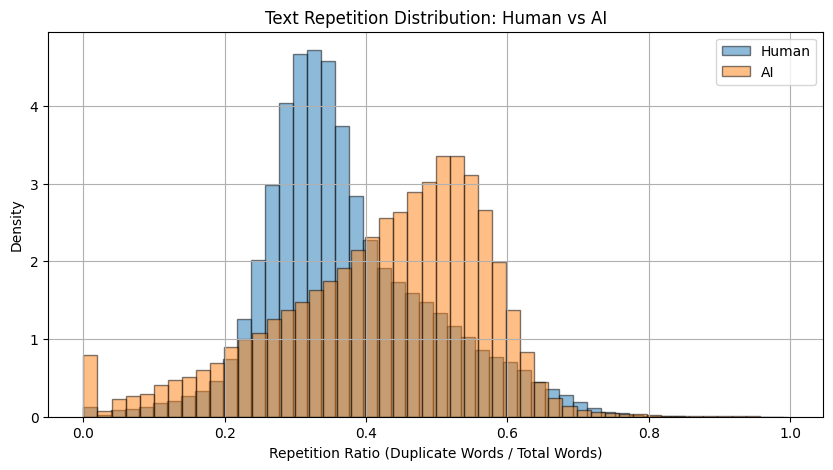

In [31]:
# Function to measure repetition (percentage of duplicate words)
def compute_repetition_ratio(text):
    words = text.lower().split()
    unique_words = set(words)
    return 1 - (len(unique_words) / len(words)) if len(words) > 0 else 0

# Compute repetition ratios for both datasets
df_human["repetition_ratio"] = df_human["text"].apply(compute_repetition_ratio)
df_ai["repetition_ratio"] = df_ai["text"].apply(compute_repetition_ratio)

# Plot repetition comparison
plt.figure(figsize=(10, 5))
plt.hist(df_human["repetition_ratio"], bins=50, alpha=0.5, label="Human", edgecolor="black", density=True)
plt.hist(df_ai["repetition_ratio"], bins=50, alpha=0.5, label="AI", edgecolor="black", density=True)
plt.xlabel("Repetition Ratio (Duplicate Words / Total Words)")
plt.ylabel("Density")
plt.title("Text Repetition Distribution: Human vs AI")
plt.legend()
plt.grid(True)
plt.show()

# Model Training

In [179]:
class TextClassifier:
    def __init__(self, model_name='roberta-base', batch_size=32, epochs=30, patience=3, learning_rate=2e-5):
        """
        Initializes the text classifier with a transformer model.

        :param model_name: Transformer model name (e.g., 'roberta-base', 'roberta-large', 'deberta-v3-large')
        :param batch_size: Training batch size
        :param epochs: Maximum number of training epochs
        :param patience: Early stopping patience
        :param learning_rate: Learning rate for AdamW optimizer
        """
        self.model_name = model_name
        self.tokenizer = self.get_tokenizer(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        # Training parameters
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.learning_rate = learning_rate

        # Optimizer and scheduler
        self.optimizer = AdamW(self.model.parameters(), lr=learning_rate)
        self.scheduler = StepLR(self.optimizer, step_size=1, gamma=0.1)

    def get_tokenizer(self, model_name):
        """Returns the appropriate tokenizer based on the model."""
        if model_name == "microsoft/deberta-v3-large":
            return DebertaV2Tokenizer.from_pretrained(model_name)
        return AutoTokenizer.from_pretrained(model_name)

    @staticmethod
    def clean_text(text):
        """Cleans text by removing punctuation, numbers, and converting to lowercase."""
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        return text.lower()

    def prepare_data(self, df_ai, df_human):
        """Loads and processes AI and human-generated text data."""
        df_ai['source'] = 1  # AI-generated
        df_human['source'] = 0  # Human-written
        combined_df = pd.concat([df_ai, df_human]).dropna().reset_index(drop=True)
        combined_df['text'] = combined_df['text'].apply(self.clean_text)

        # Tokenization
        inputs = self.tokenizer(list(combined_df['text']), padding=True, truncation=True, max_length=128, return_tensors='pt')
        labels = torch.tensor(combined_df['source'].values)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(inputs['input_ids'], labels, test_size=0.2, random_state=42)
        train_data = TensorDataset(X_train, y_train)
        test_data = TensorDataset(X_test, y_test)

        self.train_dataloader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        self.test_dataloader = DataLoader(test_data, batch_size=self.batch_size)

    def train(self):
        """Trains the model with early stopping."""
        best_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(self.epochs):
            self.model.train()
            total_loss, correct, total = 0, 0, 0

            print(f"\nEpoch {epoch+1} Training:")
            progress_bar = tqdm(self.train_dataloader, desc=f"Epoch {epoch+1}")

            for batch in progress_bar:
                input_ids, labels = [b.to(self.device) for b in batch]
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(input_ids, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                # Backward pass
                loss.backward()
                self.optimizer.step()

                # Update metrics
                total_loss += loss.item()
                predictions = torch.argmax(logits, dim=-1)
                correct += (predictions == labels).sum().item()
                total += len(labels)
                progress_bar.set_postfix(loss=loss.item())

            accuracy = correct / total
            print(f"\nEpoch {epoch+1} completed: Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

            # Early Stopping
            if total_loss < best_loss:
                best_loss = total_loss
                epochs_no_improve = 0
                torch.save(self.model.state_dict(), f"best_model_{self.model_name}_{epoch}.pth")
                print("✅ Best model so far! Saving...")
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= self.patience:
                print(f"⏹️ Early stopping triggered after {epoch+1} epochs.")
                break

    def evaluate(self):
        """Evaluates the model and prints classification report."""
        self.model.eval()
        y_pred, y_true = [], []

        print("\nEvaluating Model:")
        with torch.no_grad():
            progress_bar = tqdm(self.test_dataloader, desc="Evaluating")

            for batch in progress_bar:
                input_ids, labels = [b.to(self.device) for b in batch]
                outputs = self.model(input_ids)
                logits = outputs.logits

                predictions = torch.argmax(logits, dim=-1)
                y_pred.extend(predictions.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        # Print reports
        print("Classification Report:", classification_report(y_true, y_pred), end="\n\n")
        print("Confusion Matrix:", confusion_matrix(y_true, y_pred), end="\n\n")

    def predict(self, text):
        """Predicts if a given text is AI-generated or human-written."""
        text = self.clean_text(text)
        inputs = self.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt').to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(inputs['input_ids'])
            logits = outputs.logits
            prediction = torch.argmax(logits, dim=-1).item()

        return "AI-generated" if prediction == 1 else "Human-written"

    def predict_with_confidence(self, texts):
        """Predicts multiple texts with confidence scores."""
        results = []
        for text in texts:
            cleaned_text = self.clean_text(text)
            inputs = self.tokenizer(cleaned_text, padding=True, truncation=True, max_length=128, return_tensors='pt').to(self.device)

            self.model.eval()
            with torch.no_grad():
                outputs = self.model(inputs['input_ids'])
                logits = outputs.logits
                probabilities = F.softmax(logits, dim=-1)
                confidence, prediction = torch.max(probabilities, dim=-1)

            results.append({
                "text": text,
                "prediction": "AI-generated" if prediction.item() == 1 else "Human-written",
                "confidence": confidence.item()
            })

        return results

# Execution

In [180]:
# # List of models to train
# models = ["roberta-base", "roberta-large", "microsoft/deberta-v3-large"]

# for model_name in models:
#     print(f"🔥 Training with {model_name}", end="\n\n")
#     classifier = TextClassifier(model_name=model_name, epochs=10)
#     classifier.prepare_data(df_ai, df_human)
#     classifier.train()
#     classifier.evaluate()

# print("Training & Evaluation Completed")

# Evaluation Analysis

In [181]:
# Set style
sns.set_theme(style="whitegrid")

models = ["RoBERTa-Base", "RoBERTa-Large", "DeBERTa-V3 Large"]

# ---------------------- Classification Report Data ----------------------
# Precision, Recall, F1-Score, and Accuracy for each model
classification_reports = {
    "RoBERTa-Base": {
        "Precision": [0.99, 0.94], "Recall": [0.93, 0.99], "F1-Score": [0.96, 0.96], "Accuracy": 0.96
    },
    "RoBERTa-Large": {
        "Precision": [0.00, 0.50], "Recall": [0.00, 1.00], "F1-Score": [0.00, 0.66], "Accuracy": 0.50
    },
    "DeBERTa-V3 Large": {
        "Precision": [0.57, 0.89], "Recall": [0.97, 0.27], "F1-Score": [0.72, 0.41], "Accuracy": 0.62
    }
}

# Confusion matrices for each model
confusion_matrices = {
    "RoBERTa-Base": np.array([[18772, 1326], [115, 19779]]),
    "RoBERTa-Large": np.array([[0, 20098], [0, 19894]]),
    "DeBERTa-V3 Large": np.array([[19446, 652], [14620, 5274]])
}

### Classification Report

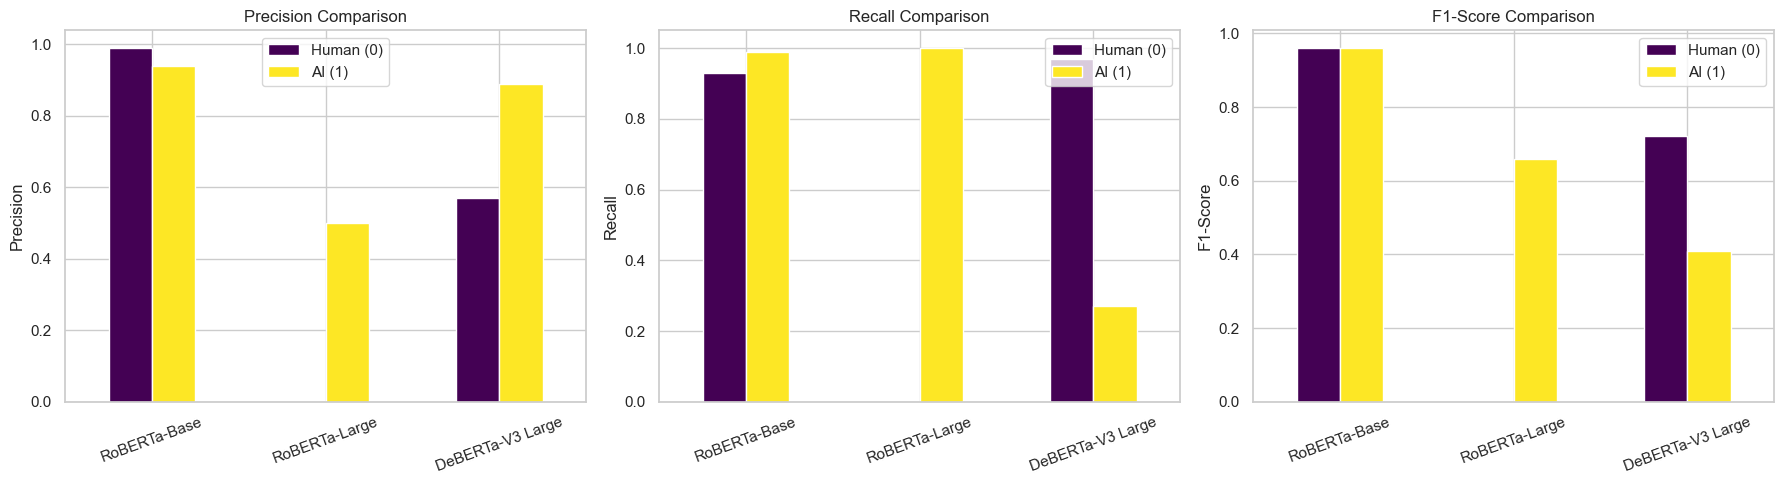

In [182]:
def plot_classification_report():
    """Plots Precision, Recall, and F1-Score for all models"""
    metrics = ["Precision", "Recall", "F1-Score"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, metric in enumerate(metrics):
        values = [classification_reports[model][metric] for model in models]
        df = pd.DataFrame(values, index=models, columns=["Human (0)", "AI (1)"])

        df.plot(kind="bar", ax=axes[i], colormap="viridis")
        axes[i].set_title(f"{metric} Comparison")
        axes[i].set_ylabel(metric)
        axes[i].set_xticklabels(models, rotation=20)

    plt.tight_layout()
    plt.show()


plot_classification_report()  # Precision, Recall, F1-Score

### Accuracy Comparison

C:\Users\Owner\AppData\Local\Temp\ipykernel_26440\1762199372.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="viridis")


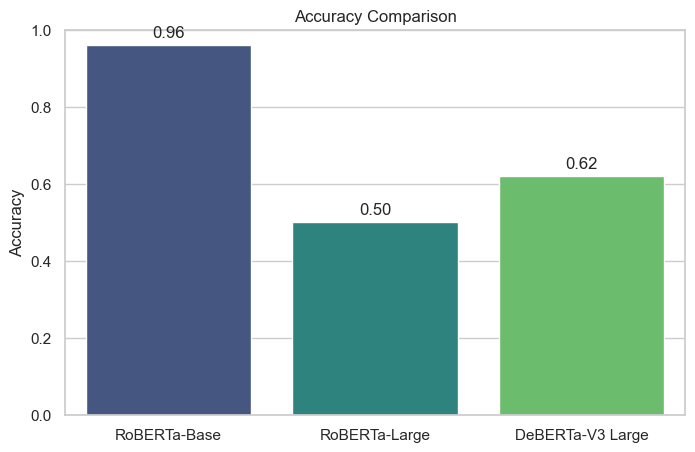

In [183]:
def plot_accuracy():
    """Plots the Accuracy comparison for all models"""
    accuracies = [classification_reports[model]["Accuracy"] for model in models]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=models, y=accuracies, palette="viridis")
    plt.title("Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=12)

    plt.show()


plot_accuracy()               # Accuracy Comparison

### Confusion Matrices

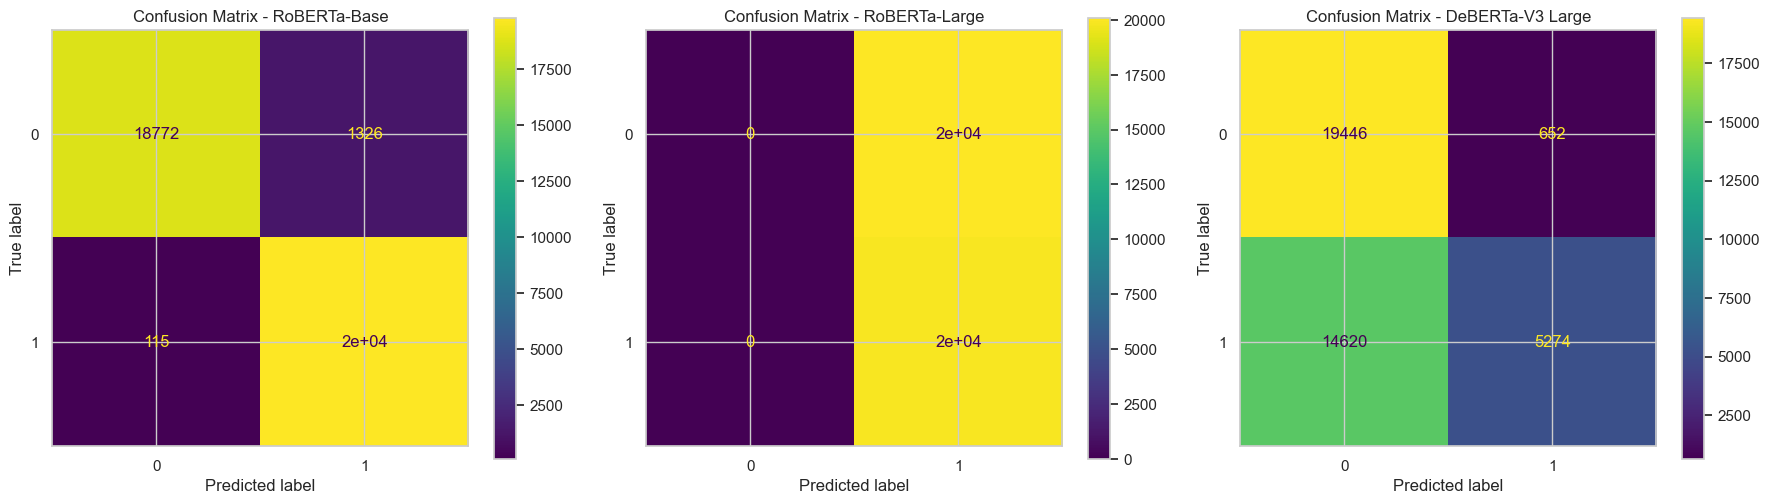

In [184]:
def plot_confusion_matrices():
    """Plots the confusion matrices for all models"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, model in enumerate(models):
        ax = axes[i]
        ConfusionMatrixDisplay(confusion_matrices[model]).plot(cmap="viridis", ax=ax)
        ax.set_title(f"Confusion Matrix - {model}")

    plt.tight_layout()
    plt.show()


plot_confusion_matrices()      # Confusion Matrices